In [1]:
from IPython import display
from music21 import environment
import verovio
from verovio import toolkit
import xml.etree.ElementTree as ET

In [34]:
import xml.etree.ElementTree as ET

class Note:
    def __init__(self, pitch: int, length: int):
        self.pitch = pitch #0-88
        self.length = length #number of ratoms, or rhythmic atoms. e.g. if self.ratom=16, the rhythmic atom is a semiquaver, and the length of a crotchet is 16.

    def transpose(self, interval: int):
        self.pitch += interval

    def __str__(self):
        return f"{self.pitch}({self.length})"

    def copy(self):
        return Note(self.pitch, self.length)

class NotePlus(Note):
    def __init__(self, pitch: int, length: int, tie=False):
        super().__init__(pitch, length)
        self.tie = tie

    def copy(self):
        return NotePlus(self.pitch, self.length, self.tie)

    def __str__(self):
        return super().__str__() + self.tie * "t"
    
class Piece:
    def __init__(self, notes=None, nvoices=0, ratom=16, metadata={}):
        self.metadata = metadata # e.g {"composer":"JS Bach", "title":"Chorale from Meine Seel erhebt den Herren", "opus": "BWV 10.7"}
        self.notes = notes if notes is not None else [[[]] for _ in range(nvoices)]
        self.bars = [] # e.g if a ratom is a semiquaver and the first bar is a crotchet long: [{"length":4, "n":1},{"length":12, "n":15},{"length":8, "n":1}]
        self.keysigs = [] # e.g. [{"ks":2s, "nbars":16}] for a 16 bar piece in D major with no key changes
        self.harm_key = {} # e.g. {"tonic":('g','n'),"mode":"major"}
        self.timesigs = [] # e.g. [{"ts":[4,4],"nbars":16}]
        self.clefs = [] # 
        self.annotations = {} # e.g. {"fermata":[[48,120],[48,120],[48,120],[48,120]], "dynamics":[{"f":0, "p":4, "dim":[0,4]},{...},{...},{...}], with an object for each part referring to indices of ratoms to which they are assigned
        self.ratom = ratom # the rhythmic atom, i.e. the smallest rhythmic unit used. The numbers are as used in time signatures, i.e. 16 is a semiquaver.

    def getlength(self):
        total = 0
        for sec in self.notes[0]:
            for note in sec:
                total += note.length
        return total
        
    def transpose(self, interval: int):
        for voice in self.notes:
            for sec in voice:
                for note in sec:
                    note.transpose(interval)

    def __str__(self):
        out = []
        for i, voice in enumerate(self.notes):
            out.append([])
            for j, sec in enumerate(voice):
                out[i].append([])
                for k, note in enumerate(sec):
                    out[i][j].append(str(note))
        return str(out)


    def quantise(self, unitlength=4):
        notescopy = [[[note.copy() for note in unit] for unit in voice] for voice in self.notes]
        for i, voice in enumerate(notescopy):
            while len(voice) > 1:
                voice[0] += voice.pop(1)
            notescopy[i] = voice[0]
        quantised = []
        for i, voice in enumerate(notescopy):
            quantised.append([])
            unit, remainder = [], unitlength
            while len(voice) > 0:
                if voice[0].length == 0:
                    voice.pop(0)
                else:
                    length_to_add = min(remainder, voice[0].length)
                    tied = voice[0].tie if isinstance(voice[0],NotePlus) else voice[0].length > remainder
                    if len(unit) > 0 and unit[-1].tie:
                        unit[-1].length += length_to_add
                        unit[-1].tie = tied
                    else:
                        unit.append(NotePlus(voice[0].pitch,length_to_add,tied))
                    remainder -= length_to_add
                    voice[0].length -= length_to_add
                    if remainder == 0:
                        quantised[i].append(unit)
                        unit, remainder = [], unitlength
            if sum([n.length for n in quantised[i][-1]]) < remainder:
                unit.append(NotePlus(0,remainder))
                quantised[i].append(unit)
        return Piece(quantised)

    def addbars(self):
        quantised = self.quantise(1)
        counter = 0
        piecewithbars = [[] for voice in quantised.notes]
        for section in self.bars:
            workingnotes = Piece([[[unit[0].copy() for unit in voice[counter:counter+(section["length"]*section["n"])]]] for voice in quantised.notes])
            sectionwithbars = workingnotes.quantise(section["length"])
            for i, voice in enumerate(piecewithbars):
                voice.extend(sectionwithbars.notes[i])
        
        new_piece = Piece(piecewithbars, nvoices=len(piecewithbars), ratom=self.ratom, metadata=self.metadata.copy())
        new_piece.bars = [bar.copy() for bar in self.bars]
        new_piece.keysigs = [keysig.copy() for keysig in self.keysigs]
        new_piece.harm_key = self.harm_key.copy()
        new_piece.timesigs = [timesig.copy() for timesig in self.timesigs]
        new_piece.clefs = [clef.copy() for clef in self.clefs]
        new_piece.annotations = {k: [item.copy() for item in v] for k, v in self.annotations.items()}

        return new_piece
                          
        
    @staticmethod
    def from_mei(path,ratom=16):
        namespace = "{http://www.music-encoding.org/ns/mei}" #all tags will by default have the namespace attached at the front.
        tree = ET.parse(path)

        def _addaccidges(tree):
            for note in tree.iter(namespace+'note'):
                accid = note.find(namespace+'accid')
                if accid is not None:
                    val = accid.get('accid')
                    note.set('accid.ges', val)

        
        def reststonotes(tree):
            # changes rests to notes with pname and oct 'x'
            for rest in tree.iter(namespace + 'rest'):
                rest.tag = namespace + 'note'
                rest.set("pname","x")
                rest.set("oct","-1")
        
        def pitch_from_scientific(note,oct,accid = "n"):
            # translates to the number counting up from A0
            if note == "x":
                return 0
            map = {"c":4, "d":6, "e":8, "f":9, "g":11, "a":13, "b":15}
            basepitch = (oct-1)*12 + map[note]
            if accid == "n":
                return basepitch
            if accid == "s":
                return basepitch + 1
            if accid == "f":
                return basepitch - 1
            if accid == "ss":
                return basepitch + 2
            if accid == "ff":
                return basepitch - 2
 
        def durtolen(dur,dots=0):
            length = ratom * 2 if dur == 0 else ratom // dur
            duplength = length
            for _ in range(dots):
                duplength = duplength // 2
                length += duplength
            return length
                
        def piecefromtree(tree):
            nvoices=0
            for _ in tree.iter(namespace + 'staffDef'):
                nvoices += 1
            piece = Piece(nvoices=nvoices)
            ties = [False for _ in range(nvoices)]
            for ts in tree.iter(namespace + 'meterSig'):# Hacky. To be changed at some point to deal with pieces with more than one time signature.
                barlength = int(ts.get('count')) * ratom // int(ts.get('unit'))
                break
            rpts = [] #to keep track of repeats in order to copy out repeated notes twice
            rptstart = 0
            for staffn in range(nvoices):
                for measure in tree.iter(namespace + 'measure'):
                    if staffn == 0 and measure.get('left') == "rptstart":
                        rptstart = len(piece.notes[staffn][0])
                    if staffn == 0 and measure.get('right') == "rptend":
                        rptendbarstart = len(piece.notes[staffn][0])
                        rpts.append([rptstart, rptendbarstart])
                    barrest = True
                    for staff in measure.iter(namespace + 'staff'):
                        if int(staff.get('n')) == staffn + 1:
                            for note in staff.iter(namespace + 'note'):
                                barrest = False
                                dots = int(note.get('dots')) if note.get('dots') else 0
                                if ties[staffn]:
                                    piece.notes[staffn][0][-1] += durtolen(int(note.get('dur')),dots)
                                    ties[staffn] = False
                                else:
                                    accid = note.get('accid.ges') if note.get('accid.ges') else "n"
                                    newpitch = pitch_from_scientific(note.get('pname'), int(note.get('oct')), accid)
                                    newlength = durtolen(int(note.get('dur')),dots)
                                    piece.notes[staffn][0].append(Note(newpitch,newlength))
                                for tie in measure.iter(namespace + 'tie'):
                                    if tie.get('startid') == note.get('id'):
                                        ties[staffn] = True
                                        break
                    if barrest:
                        piece.notes[staffn][0].append(Note(0, barlength))
            # Duplicate notes in repeated sections
            for voice in piece.notes:
                for rpt_sec in rpts:
                    rpt_remainder = barlength
                    rpt_endindx = rpt_sec[1]
                    while rpt_remainder > 0: #will not work if there is a tie over the repeat: to be sorted out later
                        rpt_remainder -= voice[0][rpt_endindx].length
                        rpt_endindx += 1
                    voice[0][rpt_endindx:rpt_endindx] = [note.copy() for note in voice[0][rpt_sec[0]:rpt_endindx]]
                
            return piece
        reststonotes(tree)
        _addaccidges(tree)
        return piecefromtree(tree)

    

                

In [50]:
filepath = 'corpus/bach/mei_versions/bwv10.7.mei'
newpiece = Piece.from_mei(filepath)
newpiece = newpiece.quantise(1)
notescopy = [[[note.copy() for note in unit] for unit in voice] for voice in newpiece.notes]
unitlength = 1
for i, voice in enumerate(notescopy):
    while len(voice) > 1:
        voice[0] += voice.pop(1)
    notescopy[i] = voice[0]
quantised = []
#print([[str(n) for n in voice] for voice in notescopy])
for i, voice in enumerate(notescopy):
    quantised.append([])
    unit, remainder = [], unitlength
    while len(voice) > 0:
        print(f"voice[0]: {str(voice[0])}, unit: {[str(n) for n in unit]}, remainder: {remainder}")
        if voice[0].length == 0:
            voice.pop(0)
        else:
            length_to_add = min(remainder, voice[0].length)
            tied = voice[0].tie if isinstance(voice[0],NotePlus) else voice[0].length > remainder
            print(tied)
            if len(unit) > 0 and unit[-1].tie:
                unit[-1].length += length_to_add
                unit[-1].tie = tied
            else:
                unit.append(NotePlus(voice[0].pitch,length_to_add,tied))
                print(NotePlus(voice[0].pitch,length_to_add,tied))
                print([str(n) for n in unit])
            remainder -= length_to_add
            voice[0].length -= length_to_add
            if remainder == 0:
                quantised[i].append(unit)
                unit, remainder = [], unitlength
    if sum([n.length for n in quantised[i][-1]]) < remainder:
        unit.append(NotePlus(0,remainder))
        quantised[i].append(unit)
#print(Piece(quantised).quantise(1).quantise(4))#.quantise(1))#.quantise(4))

voice[0]: 54(1)t, unit: [], remainder: 1
True
54(1)t
['54(1)t']
voice[0]: 54(0)t, unit: [], remainder: 1
voice[0]: 54(1)t, unit: [], remainder: 1
True
54(1)t
['54(1)t']
voice[0]: 54(0)t, unit: [], remainder: 1
voice[0]: 54(1)t, unit: [], remainder: 1
True
54(1)t
['54(1)t']
voice[0]: 54(0)t, unit: [], remainder: 1
voice[0]: 54(1)t, unit: [], remainder: 1
True
54(1)t
['54(1)t']
voice[0]: 54(0)t, unit: [], remainder: 1
voice[0]: 54(1)t, unit: [], remainder: 1
True
54(1)t
['54(1)t']
voice[0]: 54(0)t, unit: [], remainder: 1
voice[0]: 54(1)t, unit: [], remainder: 1
True
54(1)t
['54(1)t']
voice[0]: 54(0)t, unit: [], remainder: 1
voice[0]: 54(1)t, unit: [], remainder: 1
True
54(1)t
['54(1)t']
voice[0]: 54(0)t, unit: [], remainder: 1
voice[0]: 54(1), unit: [], remainder: 1
False
54(1)
['54(1)']
voice[0]: 54(0), unit: [], remainder: 1
voice[0]: 57(1)t, unit: [], remainder: 1
True
57(1)t
['57(1)t']
voice[0]: 57(0)t, unit: [], remainder: 1
voice[0]: 57(1)t, unit: [], remainder: 1
True
57(1)t
['57(

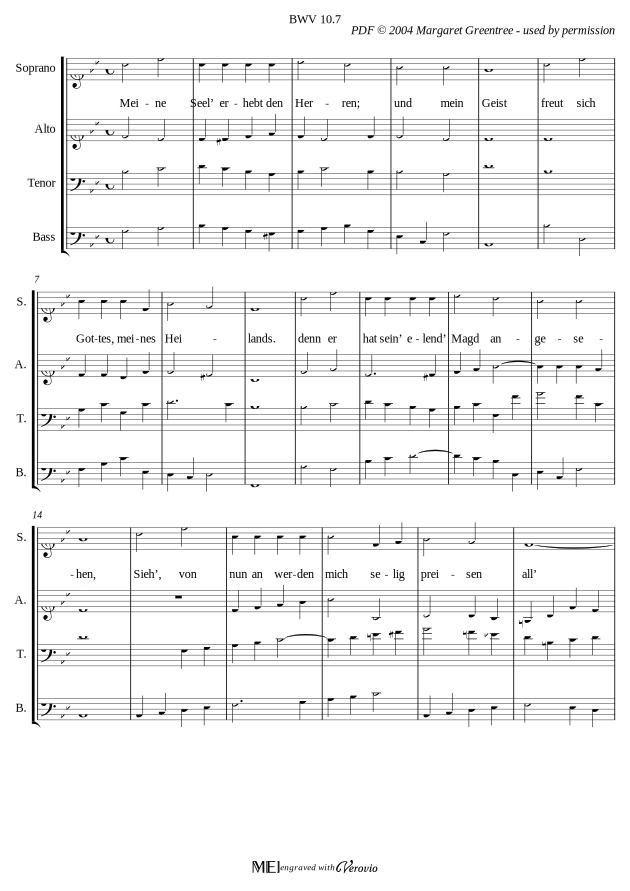

In [739]:
filepath = 'corpus/bach/mei_versions/bwv10.7.mei'
newpiece = Piece.from_mei(filepath)
vrvtoolkit.loadFile(filepath)
display.SVG(vrvtoolkit.renderToSVG())

In [741]:
newpiece.bars = [{"n":22,"length":16}]
print(newpiece.addbars())

[[['66(8)', '69(8)'], ['66(4)', '66(4)', '66(4)', '66(4)'], ['67(8)', '66(8)'], ['64(8)', '64(8)'], ['62(16)'], ['66(8)', '69(8)'], ['64(4)', '64(4)', '64(4)', '59(4)'], ['62(8)', '61(8)'], ['59(16)'], ['66(8)', '69(8)'], ['66(4)', '66(4)', '66(4)', '66(4)'], ['67(8)', '66(8)'], ['64(8)', '64(8)'], ['62(16)'], ['66(8)', '69(8)'], ['64(4)', '64(4)', '64(4)', '64(4)'], ['64(8)', '59(4)', '61(4)'], ['62(8)', '61(8)'], ['59(16)'], ['59(16)'], ['59(16)'], ['59(16)']], [['59(8)', '57(8)'], ['57(4)', '57(4)', '59(4)', '61(4)'], ['59(4)', '57(8)', '59(4)'], ['59(8)', '57(8)'], ['57(16)'], ['57(16)'], ['57(4)', '57(4)', '55(4)', '59(4)'], ['59(8)', '57(8)'], ['54(16)'], ['59(8)', '61(8)'], ['57(12)', '57(4)'], ['59(4)', '61(4)', '62(8)'], ['62(4)', '62(4)', '62(4)', '61(4)'], ['57(16)'], ['0(16)'], ['57(4)', '59(4)', '61(4)', '62(4)'], ['64(8)', '52(8)'], ['54(8)', '54(4)', '52(4)'], ['51(4)', '54(4)', '59(4)', '57(4)'], ['55(16)'], ['55(8)', '54(4)', '52(4)'], ['54(16)']], [['50(8)', '52(8)'],

In [1241]:
import random, string, numpy as np
from datetime import date
def to_mei(piece,ratom=16):

    descpowers = [piece.ratom // n for n in [2**n for n in range(int(np.log2(piece.ratom))+1)]]

    #potential data: title, composer, clefs, key signatures, time signatures?
    def _idgen():
        return 'id' + ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(10))

    def _getclefs(piece):
        clefs = []
        for voice in piece.notes:
            if np.mean([np.mean([n.pitch for n in unit]) for unit in voice]) < 45:
                clefs.append({"shape":"F", "line":4})
            else:
                clefs.append({"shape":"G", "line":2})
        return clefs

    def _getkeysigs(piece):
        #placeholder: improve later to manage pieces with key signature changes
        out = "0s"
        maxratio = 0
        for ks in reference.diatonics:
            inorout = [0,0]
            for voice in piece.notes:
                for unit in voice:
                    for note in unit:
                        if note.pitch in reference.diatonics[ks]:
                            inorout[0] +=1
                        else:
                            inorout[1] +=1
            inoutratio = inorout[0]/inorout[1]
            if inoutratio > maxratio:
                out = ks
                maxratio = inoutratio
        return [{"ks":out,"nbars":100}]
                        
        
    def _gettimesigs(piece):
        #placeholder: improve later to work out more sensibel time signatures and manage piece with time signature changes
        if len(piece.bars) == 1:
            barlength = piece.bars[0]["length"]
        elif len(piece.bars) > 1:
            barlength = piece.bars[1]["length"]
        else:
            barlength = sum([n.length for n in piece.notes[0][1]])
        ts = [barlength,ratom]
        while ts[1] > 4 and np.gcd(ts[0],ts[1]) > 1:
            ts = [ts[0] // 2,ts[1] // 2]
        return [{"ts":ts,"nbars":100}]
            

    def _lentodur(note_len):
        if note_len == ratom * 2:
            return {"dur":0, "dots":0}
        dots = 0
        for i, n in enumerate(descpowers):
            if note_len == n:
                last = i
                break
            if note_len >= n:
                note_len -= n
                dots += 1
        dur = ratom // descpowers[i-dots]                    
        return {"dur": dur,"dots": dots}
        
        
    title = "" if "title" not in piece.metadata else piece.metadata["title"]
    composer = "" if "composer" not in piece.metadata else piece.metadata["composer"]
    clefs = piece.clefs if len(piece.clefs) > 0 else _getclefs(piece)
    keysigs = piece.keysigs if len(piece.keysigs) > 0 else _getkeysigs(piece)
    timesigs = piece.timesigs if len(piece.timesigs) > 0 else _gettimesigs(piece,ratom)
    harm_key = piece.harm_key if len(piece.harm_key) > 0 else {"tonic":reference.sigtokeymap[keysigs[0]["ks"]][0],"mode":"major"}
    def _idgen():
        return 'id' + ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(10))

    ties = [False for _ in piece.notes]
    out = f"""<?xml version="1.0" encoding="UTF-8"?>
<?xml-model href="https://music-encoding.org/schema/5.0/mei-all.rng" type="application/xml" schematypens="http://relaxng.org/ns/structure/1.0"?>
<?xml-model href="https://music-encoding.org/schema/5.0/mei-all.rng" type="application/xml" schematypens="http://purl.oclc.org/dsdl/schematron"?>
<mei xmlns="http://www.music-encoding.org/ns/mei" meiversion="5.0">
    <meiHead xml:id="{_idgen()}">
        <fileDesc xml:id="{_idgen()}">
            <titleStmt xml:id="{_idgen()}">
                <title>{title}</title>
                <composer>{composer}</composer>
            </titleStmt>
            <pubStmt xml:id="{_idgen()}">
                <date>isodate="{str(date.today())}"></date>
            </pubStmt>
        </fileDesc>
        <encodingDesc xml:id="{_idgen()}">
            <appInfo xml:id="{_idgen()}">
                <application xml:id="{_idgen()}">
                    <name xml:id="{_idgen()}">Dunstaple</name>
                </application>
            </appInfo>
        </encodingDesc>
    </meiHead>
    <music>
        <body>
            <mdiv xml:id="{_idgen()}">
                <score xml:id="{_idgen()}">
                    <scoreDef xml:id="{_idgen()}">
                        <staffGrp xml:id="{_idgen()}" bar.thru="true">
                            <grpSym xml:id="{_idgen()}" symbol="bracket" />"""

    for i, voice in enumerate(piece.notes):
        out += f"""
                            <staffDef xml:id="{_idgen()}" n="{i+1}" lines="5">
                                <clef xml:id="{_idgen()}" shape="{clefs[i]["shape"]}" line="{clefs[i]["line"]}" />
                                <keySig xml:id="{_idgen()}" sig="{keysigs[0]["ks"]}" />
                                <meterSig xml:id="{_idgen()}" count="{timesigs[0]["ts"][0]}" unit="{timesigs[0]["ts"][1]}" />
                            </staffDef>"""

    out += f"""
                        </staffGrp>
                    </scoreDef>
                    <section xml:id="{_idgen()}">
                        <pb xml:id="{_idgen()}" />"""
    
    bar_count = 0 if piece.bars[0]["length"] < (ratom // timesigs[0]["ts"][1]) * timesigs[0]["ts"][0] else 1
    for i, bar in enumerate(piece.notes[0]):
        currks=keysigs[0]["ks"]
        endbar = """right="end" """ if i == len(piece.notes[0])-1 else ""
        out += f"""
                        <measure xml:id="{_idgen()}" {endbar}n="{bar_count}">"""
        for j, voice in enumerate(piece.notes):
            out += f"""
                            <staff xml:id="{_idgen()}" n="{j+1}">
                                <layer xml:id="{_idgen()}" n="1">"""
            for k, note in enumerate(voice[i]):
                [pname,oct,accidges] = pitch_to_scientific(note.pitch).values()
                [dur,dots] = _lentodur(note.length).values()
                tie_str = """tie="i" """ * note.tie + """tie="t" """ * ties[j]
                ties[j] = note.tie
                if note.pitch == 0:
                    out += f"""
                                    <rest xml:id="{_idgen()}" dots="{dots}" dur="{dur}" />"""
                    continue
                accidges_str, accid_str = "", "/>"
                need_accid, need_accidges = False, False
                enharm = enharmonic({"pname":pname,"accid":accidges},ks=currks,mode=harm_key["mode"])
                pname, accidges = enharm["pname"],enharm["accid"]
                if (accidges == "s" and currks in all_keysigs["flats"]) or (accidges =="f" and currks in all_keysigs["sharps"]):
                    need_accid = True
                elif (accidges == "s" and currks in all_keysigs["sharps"]):
                    if pname not in all_keysigs["sharps"][currks]:
                        need_accid = True
                    else:
                        need_accidges = True
                elif (accidges == "f" and currks in all_keysigs["flats"]):
                    if pname not in all_keysigs["flats"][currks]:
                        need_accid = True
                    else:
                        need_accidges = True
                elif (accidges == "n" and currks in all_keysigs["flats"]):
                    if pname in all_keysigs["flats"][currks]:
                        need_accid = True
                elif (accidges == "n" and currks in all_keysigs["sharps"]):
                    if pname in all_keysigs["sharps"][currks]:
                        need_accid = True

                if need_accidges:
                    accidges_str = f"""accid.ges="{accidges}" """
                if need_accid:
                    accid_str = f""">
                                        <accid xml:id="{_idgen()}" accid="{accidges}" />
                                    </note>"""
                out += f"""
                                    <note xml:id="{_idgen()}" dots="{dots}" dur="{dur}" oct="{oct}" pname="{pname}" {tie_str}{accidges_str}{accid_str}"""
            out += f"""
                                </layer>
                            </staff>"""
        out += f"""
                        </measure>"""
    out += f"""
                    </section>
                </score>
            </mdiv>
        </body>
    </music>
</mei>"""

    return out


In [1027]:
def pitch_to_scientific(pitch):
    oct = (pitch + 8) // 12
    pname = reference.presumed_chr_scale[(pitch) % 12][0]
    accid = reference.presumed_chr_scale[(pitch) % 12][1]
    return {"pname":pname,"oct":oct,"accid":accid}

def enharmonic(sci_pitch,ks,mode="major"):
   
    guessed_tonic = reference.sigtokeymap[ks][0] if mode == "major" else reference.sigtokeymap[ks][1]
    out = dict(sci_pitch)
    note_tuple = (sci_pitch["pname"],sci_pitch["accid"])
    for eq_tuple in reference.enharm_equivs:
        if note_tuple in eq_tuple:
            if reference.leadingnotemap[guessed_tonic] in eq_tuple:
                out["pname"], out["accid"] = reference.leadingnotemap[guessed_tonic][0],reference.leadingnotemap[guessed_tonic][1]
                return out
    if ks in reference.all_keysigs["sharps"]:
        if sci_pitch["accid"] == "f":
            for eq_tuple in reference.enharm_equivs:
                if note_tuple in eq_tuple:
                    ind = eq_tuple.index(note_tuple) - 1
                    out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                    return out
        else:
            return out
    elif ks in reference.all_keysigs["flats"]:
        if sci_pitch["accid"] == "s":
            for eq_tuple in enharm_equivs:
                if note_tuple in eq_tuple:
                    ind = eq_tuple.index(note_tuple) + 1
                    out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                    return out
    return out
        
                

In [942]:
testtk = toolkit()
testtk.loadFile('corpus/bach/mei_versions/bwv11.6.mei')
testtk.rendertoSVG

True

In [10]:
def getkeysigs(piece):
        #placeholder: improve later to manage pieces with key signature changes
        out = "0s"
        maxratio = 0
        for ks in reference.diatonics:
            inorout = [0,0]
            for voice in piece.notes:
                for unit in voice:
                    for note in unit:
                        if note.pitch in reference.diatonics[ks]:
                            inorout[0] +=1
                        else:
                            inorout[1] +=1
            inoutratio = inorout[0]/inorout[1]
            if inoutratio > maxratio:
                out = ks
                maxratio = inoutratio
        return {"ks":ks,"nbars":100}

tmppiece = Piece.from_mei('corpus/bach/mei_versions/bwv11.6.mei')
getkeysigs(tmppiece)

NameError: name 'Piece' is not defined

In [922]:
sci_pitch=pitch_to_scientific(41)
ks = "1f"
mode = "minor"
guessed_tonic = reference.sigtokeymap[ks][0] if mode == "major" else reference.sigtokeymap[ks][1]
print(guessed_tonic)
out = dict(sci_pitch)
note_tuple = (sci_pitch["pname"],sci_pitch["accid"])
for eq_tuple in reference.enharm_equivs:
    if note_tuple in eq_tuple:
        if reference.leadingnotemap[guessed_tonic] in eq_tuple:
            out["pname"], out["accid"] = reference.leadingnotemap[guessed_tonic][0],reference.leadingnotemap[guessed_tonic][1]
            print(out,"12")
            
if ks in reference.all_keysigs["sharps"]:
    if sci_pitch["accid"] == "f":
        for eq_tuple in reference.enharm_equivs:
            if note_tuple in eq_tuple:
                ind = eq_tuple.index(note_tuple) - 1
                out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                print(out,"14")
    else:
        print(out,"16")
elif ks in reference.all_keysigs["flats"]:
    if sci_pitch["accid"] == "s":
        for eq_tuple in enharm_equivs:
            if note_tuple in eq_tuple:
                ind = eq_tuple.index(note_tuple) + 1
                out["pname"], out["accid"] = eq_tuple[ind][0], eq_tuple[ind][1]
                print(out,"23")


('d', 'n')
{'pname': 'c', 'oct': 4, 'accid': 's'} 12
{'pname': 'd', 'oct': 4, 'accid': 'f'} 23


In [1219]:
import importlib
importlib.reload(reference)
print(tmppiece)

[[['51(4)', '51(4)', '49(4)', '51(4)', '53(4)', '54(4)', '53(4)', '51(4)', '51(4)', '53(4)', '53(4)', '58(4)', '56(4)', '54(8)', '53(4)', '58(4)', '51(4)', '51(4)', '49(4)', '51(4)', '53(4)', '54(4)', '53(4)', '51(4)', '51(4)', '53(4)', '53(4)', '58(4)', '56(4)', '54(8)', '53(4)', '58(4)', '56(4)', '54(4)', '53(2)', '54(2)', '56(4)', '54(4)', '53(4)', '51(4)', '54(4)', '53(4)', '51(4)', '49(2)', '47(2)', '46(2)', '48(2)', '49(2)', '51(2)', '51(4)', '53(4)', '53(4)', '54(4)', '56(4)', '58(6)', '56(2)', '54(4)', '56(4)', '53(8)', '51(12)']], [['46(4)', '44(4)', '46(4)', '46(4)', '47(2)', '49(2)', '51(4)', '49(4)', '46(4)', '46(2)', '47(2)', '49(4)', '49(2)', '47(2)', '46(4)', '47(2)', '49(2)', '51(8)', '46(4)', '44(4)', '46(4)', '46(4)', '47(2)', '49(2)', '51(4)', '49(4)', '46(4)', '46(2)', '47(2)', '49(4)', '49(2)', '47(2)', '46(4)', '47(2)', '49(2)', '51(8)', '49(4)', '49(4)', '49(2)', '47(2)', '46(2)', '47(2)', '49(2)', '51(2)', '53(4)', '51(4)', '49(4)', '46(4)', '46(2)', '47(2)', '4

In [1261]:

filepath = "corpus/bach/mei_versions/bwv113.8.mei"
tmppiece = Piece.from_mei(filepath)
tmppiece.bars = [{"n":1,"length":4},{"n":14,"length":16},{"n":1,"length":12}]
tmppiece.harm_key = {"tonic":('b','n'),"mode":"minor"}
realtestmei = to_mei(tmppiece.addbars())

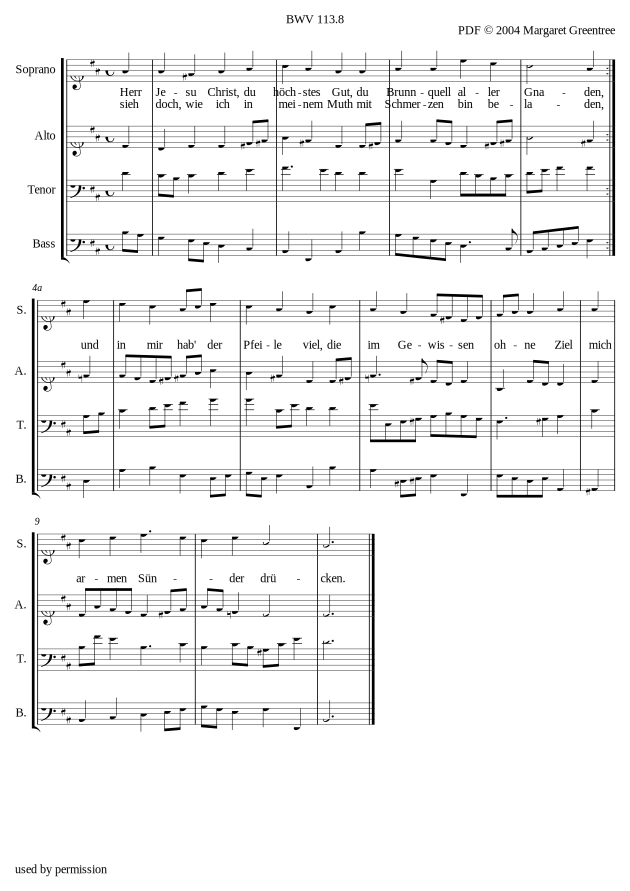

In [1231]:
vrvtoolkit.loadFile(filepath)
display.SVG(vrvtoolkit.renderToSVG())

In [1262]:
realtesttk = toolkit()
rtm = ET.fromstring(realtestmei)
realtesttk.loadData(realtestmei)

[Warning] Unable to match @tie of note 'idcibML6rLtz', skipping it


True

In [1259]:
tree = ET.parse(filepath)
root = tree.getroot()
for note in root.iter(namespace+"note"):
    accid = note.find(namespace+"accid")
    if accid is not None:
        val = accid.get('accid')
        note.set('accid.ges', val)
        print(note.attrib)

{'{http://www.w3.org/XML/1998/namespace}id': 'n5gw8dk', 'dur.ppq': '10080', 'dur': '4', 'oct': '4', 'pname': 'a', 'stem.dir': 'up', 'accid.ges': 's'}
{'{http://www.w3.org/XML/1998/namespace}id': 'n1ob217z', 'dur.ppq': '5040', 'dur': '8', 'oct': '4', 'pname': 'g', 'stem.dir': 'up', 'accid.ges': 's'}
{'{http://www.w3.org/XML/1998/namespace}id': 'nk7hp21', 'dur.ppq': '5040', 'dur': '8', 'oct': '4', 'pname': 'a', 'stem.dir': 'up', 'accid.ges': 's'}
{'{http://www.w3.org/XML/1998/namespace}id': 'nkjguwf', 'dur.ppq': '10080', 'dur': '4', 'oct': '4', 'pname': 'a', 'stem.dir': 'up', 'accid.ges': 's'}
{'{http://www.w3.org/XML/1998/namespace}id': 'ny4ag7g', 'dur.ppq': '5040', 'dur': '8', 'oct': '4', 'pname': 'g', 'stem.dir': 'up', 'accid.ges': 's'}
{'{http://www.w3.org/XML/1998/namespace}id': 'nq918hz', 'dur.ppq': '5040', 'dur': '8', 'oct': '4', 'pname': 'g', 'stem.dir': 'up', 'accid.ges': 's'}
{'{http://www.w3.org/XML/1998/namespace}id': 'nb4hili', 'dur.ppq': '5040', 'dur': '8', 'oct': '4', 'pna

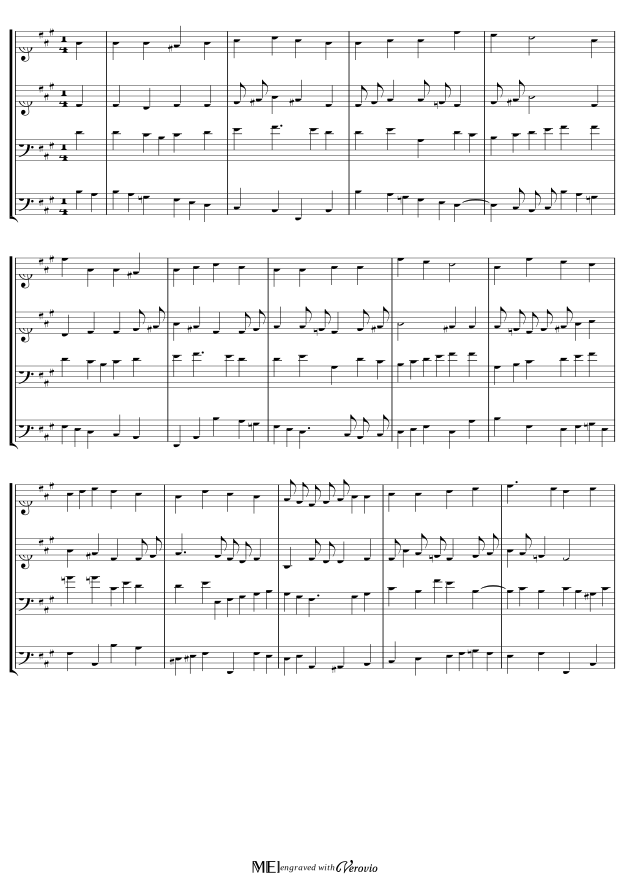

In [1263]:
realtesttk.setScale(30)
display.SVG(realtesttk.renderToSVG())


In [9]:
def testlentodur(note_len,ratom):
    if note_len == ratom * 2:
        return {"dur":0, "dots":0}
    dots = 0
    i, n = 0, ratom
    while n >=1:
        if note_len == n:
            break
        if note_len >= n:
            note_len -= n
            dots += 1
        i +=1
        n = n // 2
    dur = ratom // (n * 2 ** dots)                    
    return {"dur": dur,"dots": dots}
testlentodur(6,8)


{'dur': 2, 'dots': 1}

In [998]:
#copypasted randomly

add 
sort out accidentals: track bar
time signaturees        
clean up (e.g. helper functions and standardise
beams
NB will need to always add bars first atm.
NB need to add accidental tracking for bars
NB need to work out what happens with e.g. minim tied to a quaver

                        <staffDef xml:id="P3" n="3" lines="5" ppq="10080">
                           <label xml:id="l18qpvht">Tenor</label>
                           <labelAbbr xml:id="l507hyh">T.</labelAbbr>
                           <clef xml:id="c1x0tu7i" shape="F" line="4" />
                           <keySig xml:id="k1uvz9ud" mode="major" sig="1f" />
                           <meterSig xml:id="m10umg10" count="4" sym="common" unit="4" />
                        </staffDef>
                        <staffDef xml:id="P4" n="4" lines="5" ppq="10080">
                           <label xml:id="llzq9ps">Bass</label>
                           <labelAbbr xml:id="l1pm459o">B.</labelAbbr>
                           <clef xml:id="cbcy6m5" shape="F" line="4" />
                           <keySig xml:id="k92k6v8" mode="major" sig="1f" />
                           <meterSig xml:id="mzo3rb0" count="4" sym="common" unit="4" />
                        </staffDef>
                     </staffGrp>
                </staffGrp>
            </scoreDef>
                <section xml:id="s1yv9bm2">
                  <pb xml:id="pgqogga" />
                  <measure xml:id="m1a5nia5" n="0">
                     <staff xml:id="s1gp9v30" n="1">
                        <layer xml:id="l1e386xv" n="1">
                           <note xml:id="n1rk7i6z" dur.ppq="10080" dur="4" oct="4" pname="a" stem.dir="up">
                              <verse xml:id="vl5ygaj" label="2" n="2">
                                 <syl xml:id="shqsh55" con="s" wordpos="s">Nimm</syl>
                              </verse>
                           </note>
                        </layer>
                     </staff>
                     <staff xml:id="s4etu98" n="2">
                        <layer xml:id="lmq93ly" n="1">
                           <note xml:id="n1v7zl3f" dur.ppq="10080" dur="4" oct="4" pname="f" stem.dir="up" />
                        </layer>
                     </staff>
                     <staff xml:id="sca4d9b" n="3">
                        <layer xml:id="lxq7z35" n="1">
                           <note xml:id="ntj93i3" dur.ppq="10080" dur="4" oct="4" pname="d" stem.dir="down" />
                        </layer>
                     </staff>
                     <staff xml:id="s4qbqqk" n="4">
                        <layer xml:id="l1v35o7d" n="1">
                           <note xml:id="n1allrl8" dur.ppq="10080" dur="4" oct="3" pname="d" stem.dir="down" />
                        </layer>
                     </staff>
                  </measure>
                  <measure xml:id="m11x69at" n="1">
                     <staff xml:id="s10eomx1" n="1">
                        <layer xml:id="lwuszjp" n="1">
                           <note xml:id="n18xo3kw" dur.ppq="10080" dur="4" oct="4" pname="a" stem.dir="up">
                              <verse xml:id="vv10a7a" label="2" n="2">
                                 <syl xml:id="sa9vmpx" con="s" wordpos="s">von</syl>
                              </verse>
                           </note>
                           <note xml:id="nhcxoqz" dur.ppq="10080" dur="4" oct="4" pname="f" stem.dir="up">
                              <verse xml:id="v132j11s" label="2" n="2">
                                 <syl xml:id="s1e2x8z9" con="s" wordpos="s">uns,</syl>
                              </verse>
                           </note>
                           <note xml:id="nc1i9vv" dur.ppq="10080" dur="4" oct="4" pname="g" stem.dir="up">
                              <verse xml:id="v19ff02t" label="2" n="2">
                                 <syl xml:id="smdyg04" con="s" wordpos="s">Herr,</syl>
                              </verse>
                           </note>
                           <note xml:id="n129itr0" dur.ppq="10080" dur="4" oct="4" pname="a" stem.dir="up">
                              <verse xml:id="v1pg8m1b" label="2" n="2">
                                 <syl xml:id="s1npfkmb" con="s" wordpos="s">du</syl>
                              </verse>
                           </note>
                        </layer>
                     </staff>
                     <staff xml:id="s11edw3i" n="2">
                        <layer xml:id="l1eanqjq" n="1">
                           <note xml:id="n7yo4w5" dur.ppq="10080" dur="4" oct="4" pname="e" stem.dir="up" />
                           <note xml:id="n1w74zkz" dur.ppq="10080" dur="4" oct="4" pname="d" stem.dir="up" />
                           <note xml:id="n147rby" dur.ppq="10080" dur="4" oct="4" pname="d" stem.dir="up" />
                           <note xml:id="n16jityl" dur.ppq="10080" dur="4" oct="4" pname="d" stem.dir="up" />
                        </layer>
                     </staff>
                     <staff xml:id="s1b8vigf" n="3">
                        <layer xml:id="l192mqqf" n="1">
                           <note xml:id="n18ljxe9" dur.ppq="10080" dur="4" oct="3" pname="a" stem.dir="down" />
                           <note xml:id="n1qz9c4y" dur.ppq="10080" dur="4" oct="3" pname="a" stem.dir="down" />
                           <note xml:id="nqsa3dr" dur.ppq="10080" dur="4" oct="3" pname="b" stem.dir="down" accid.ges="f" />
                           <note xml:id="nxfuf5u" dur.ppq="10080" dur="4" oct="3" pname="a" stem.dir="down" />
                        </layer>
                     </staff>
                     <staff xml:id="s16z19h" n="4">
                        <layer xml:id="lcftmoo" n="1">
                           <note xml:id="n1fdxlpi" dur.ppq="10080" dur="4" oct="3" pname="c" stem.dir="up">
                              <accid xml:id="aq17hxo" accid="s" />
                           </note>
                           <note xml:id="n1f2n64x" dur.ppq="10080" dur="4" oct="3" pname="d" stem.dir="down" />
                           <note xml:id="n26yfot" dur.ppq="10080" dur="4" oct="3" pname="b" stem.dir="down" accid.ges="f" />
                           <note xml:id="n1tllv2b" dur.ppq="10080" dur="4" oct="3" pname="f" stem.dir="down" />
                        </layer>
                     </staff>
                  </measure>
                  </section>
                  </score>
                  </mdiv>
                  </body>
                  </music>
                  </mei>"""


(40, 42, 44, 45, 47, 49, 51)
(33, 35, 37, 38, 40, 42, 44)
(26, 28, 30, 31, 33, 35, 37)
(19, 21, 23, 24, 26, 28, 30)
(12, 14, 16, 17, 19, 21, 23)
(5, 7, 9, 10, 12, 14, 16)
(-2, 0, 2, 3, 5, 7, 9)
(-9, -7, -5, -4, -2, 0, 2)


{'0s': {1, 3, 4, 6, 8, 9, 11, 13, 15, 16, 18, 20, 21, 23, 25, 27, 28, 30, 32, 33, 35, 37, 39, 40, 42, 44, 45, 47, 49, 51, 52, 54, 56, 57, 59, 61, 63, 64, 66, 68, 69, 71, 73, 75, 76, 78, 80, 81, 83, 85, 87}, '1s': {1, 3, 4, 6, 8, 10, 11, 13, 15, 16, 18, 20, 22, 23, 25, 27, 28, 30, 32, 34, 35, 37, 39, 40, 42, 44, 46, 47, 49, 51, 52, 54, 56, 58, 59, 61, 63, 64, 66, 68, 70, 71, 73, 75, 76, 78, 80, 82, 83, 85, 87}, '2s': {1, 3, 5, 6, 8, 10, 11, 13, 15, 17, 18, 20, 22, 23, 25, 27, 29, 30, 32, 34, 35, 37, 39, 41, 42, 44, 46, 47, 49, 51, 53, 54, 56, 58, 59, 61, 63, 65, 66, 68, 70, 71, 73, 75, 77, 78, 80, 82, 83, 85, 87}, '3s': {1, 3, 5, 6, 8, 10, 12, 13, 15, 17, 18, 20, 22, 24, 25, 27, 29, 30, 32, 34, 36, 37, 39, 41, 42, 44, 46, 48, 49, 51, 53, 54, 56, 58, 60, 61, 63, 65, 66, 68, 70, 72, 73, 75, 77, 78, 80, 82, 84, 85, 87}, '4s': {1, 3, 5, 7, 8, 10, 12, 13, 15, 17, 19, 20, 22, 24, 25, 27, 29, 31, 32, 34, 36, 37, 39, 41, 43, 44, 46, 48, 49, 51, 53, 55, 56, 58, 60, 61, 63, 65, 67, 68, 70, 72, 73

In [15]:
#https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [17]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 3, just so you can see what they look like.
print(ngrams[:3])



[(['forty', 'When'], 'winters'), (['winters', 'forty'], 'shall'), (['shall', 'winters'], 'besiege')]


In [ ]:
vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


In [21]:
nn.Module.__init__??

Signature: nn.Module.__init__(self, *args, **kwargs) -> None
Source:   
    def __init__(self, *args, **kwargs) -> None:
        """Initialize internal Module state, shared by both nn.Module and ScriptModule."""
        torch._C._log_api_usage_once("python.nn_module")

        # Backward compatibility: no args used to be allowed when call_super_init=False
        if self.call_super_init is False and bool(kwargs):
            raise TypeError("{}.__init__() got an unexpected keyword argument '{}'"
                            "".format(type(self).__name__, next(iter(kwargs))))

        if self.call_super_init is False and bool(args):
            raise TypeError(f"{type(self).__name__}.__init__() takes 1 positional argument but {len(args) + 1} were"
                            " given")

        """
        Calls super().__setattr__('a', a) instead of the typical self.a = a
        to avoid Module.__setattr__ overhead. Module's __setattr__ has special
        handling for parameters, submo

In [ ]:

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["beauty"]])